In [1]:
# we need the cell in this code so that we can import modules from the parent directory.
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
# set the size of the plots
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 5

In [3]:
from colag.colag import Colag
colag = Colag.from_tsvs('../data/COLAG_2011_ids.txt', '../data/irrelevance-output.txt')

# English has no sentences "relevant to" Wh-movement.

That sounds weird, doesn't it? What's up with that?

In the graph below, each bar categorizes each of the 

In [4]:
len(colag.language[611])

360

360 sentences in Colag English (language 611) as either a globally valid trigger for 0 or 1, ambiguous but still relevant to the value-setting of a parameter, or irrelevant to the value-settings of a parameter. The irrelevant sentences are omitted from the graph.

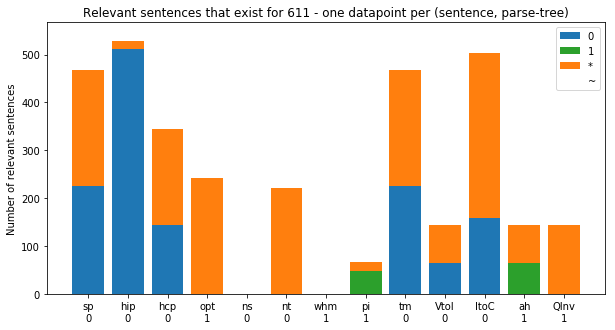

In [5]:
import visualization
visualization.plot_trigger_list(colag, 611)

# Data Tangent

But wait a sec, we just said there are 360 sentences in english, why is the y-axis running up to ~600?

In [6]:
len(colag.grammar_irr[611])

540

Huh. 

``colag.grammar_irr[611]`` is the _list_ of irrelevance strings for all sentences in Colag English.

``colag.language[611]`` is the _set_ of all sentences in Colag English.

So I think we computed the irrelevance string for every (sentence, parse tree) pair in Colag English. Let's confirm this.

In [7]:
import pandas as pd

raw_colag = pd.read_csv('../data/COLAG_2011_ids.txt', 
                        sep='\t', 
                        header=None, 
                        names=['grammar', 'sentence', 'tree'])
raw_colag.head(2)

,grammar,sentence,tree
0,132,1282,6
1,132,1282,3375


In [8]:
# how many rows (grammar, sentence, tree) are there for grammar=611?
len(raw_colag[raw_colag.grammar.eq(611)])

540

It checks out.


Ok, so how does it look if we collapse across parse trees- only one irrelevance string per sentence.

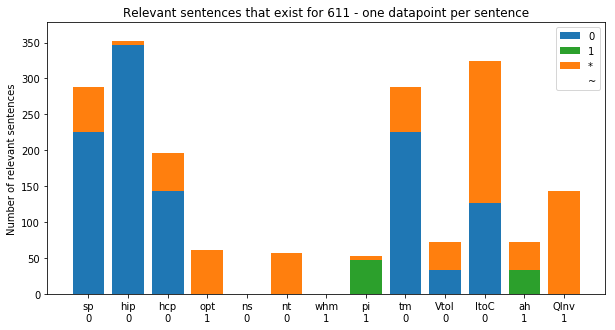

In [9]:
visualization.plot_unique_triggers(colag, 611)

Ok... so let's compare the two

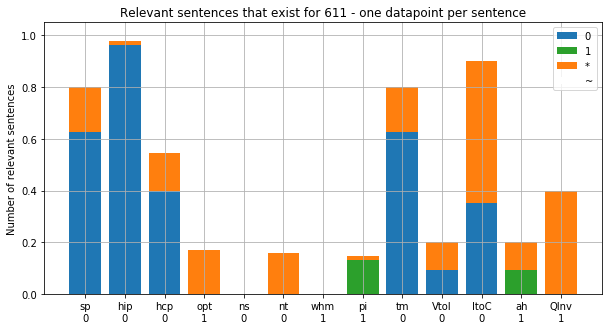

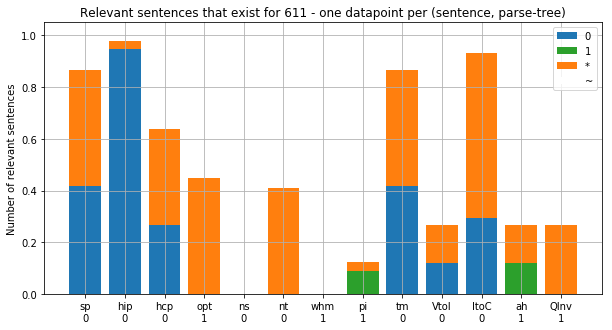

In [69]:
plt.grid(True)
visualization.plot_unique_triggers(colag, 611, normed=True)
plt.grid(True)
visualization.plot_trigger_list(colag, 611, normed=True)

# Sampling across Sentences vs (Sent, Struct) tuples

I'm not sure what to title the table below, but here's how you read it.

Look at the SP column:

This columns says that if you were to take a uniform distribution of sentences from the set of **unique (sentence, tree) pairs** rather than the set of **unique sentences**, then compared to sampling from unique sentences you would:

- sample 67% as many globally valid triggers
- sample 67% as many irrelevant sentences
- sample 2.6x as many relevant but ambiguous sentences.

In [72]:
from colag.colag import parameters

target = 611

trigger_list = colag.grammar_irr[target]
trigger_list = (pd.DataFrame(list(map(list, trigger_list)))
                    .apply(pd.Series.value_counts, axis=0)
                    .fillna(0))
trigger_list = trigger_list.div(trigger_list.sum())

trigger_set = [colag.sentence_irr[s] for s in colag.language[target]]
trigger_set = (
    pd.DataFrame(list(map(list, trigger_set)))
        .apply(pd.Series.value_counts, axis=0)
        .fillna(0))
trigger_set = trigger_set.div(trigger_set.sum())

d = trigger_list.div(trigger_set)

d.columns = parameters
d.round(2)

,sp,hip,hcp,opt,ns,nt,whm,pi,tm,VtoI,ItoC,ah,QInv
*,2.60,2.00,2.52,2.60,NaN,2.6,NaN,2.67,2.60,1.33,1.16,1.33,0.67
0,0.67,0.98,0.67,NaN,NaN,NaN,NaN,NaN,0.67,1.33,0.84,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67,NaN,NaN,NaN,1.33,NaN
~,0.67,0.92,0.80,0.67,1.0,0.7,1.0,1.02,0.67,0.92,0.67,0.92,1.22


Ok, so increasing the sentences that have multiple parses (aka have structural ambiguity) increases the amount of ambiguity we see. 

I guess we didn't learn much. But it's good to think about these two different methods of sampling I guess.

## TODO: Which sampling method do our learners use?

per sentence or per-(sentence, tree)

- NDChild
- William VL
- Paul VL

# Anyway, back to the main point

Which was, how do we explain this

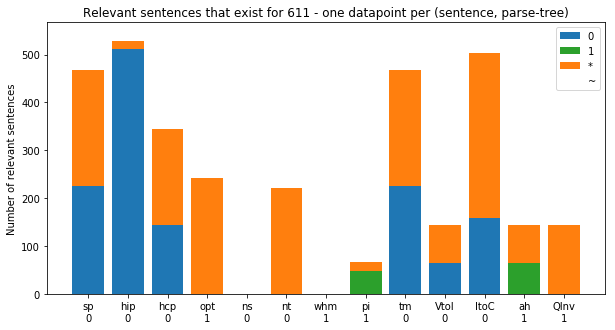

In [71]:
import visualization
visualization.plot_trigger_list(colag, 611)

Which reads like 

**"in colag english, all sentences are irrelevant wrt setting the value of the Wh-Movement parameter"**

It seems like it might be related to the fact that there are superset languages of 611 that differ by a single parameter.

Given a grammar $g$, and $S^g$, the set of grammars that are supersets of $g$,

$ \forall s \in S^g $ where $hamming(s, g) = 1$, will be an instance where we'll never see a relevant parameter.

# A weird idea

What if instead of computing these relevance string based on a hamming distance of 1 we did it on 2 or 3 ... ?

For the case of 2, we'd say

Given a sentence $S$ and a grammar $g$ that generates it, generate the set $G$- all the grammars that are a hamming distance of 2 away from $g$.

How many of these grammars does S parse in?

$\frac{\text{# of grammars in $G$ that parse s}}{G}$

What does this mean? Is this a way to find conditioned triggers?